In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from mypipes import *
%matplotlib inline

In [2]:
file = r'C:\Users\chirag\Desktop\ML IITK\Untitled Folder\DATA\census_income.csv'

In [3]:
ci_train=pd.read_csv(file)

In [4]:
ci_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
cat_vars=list(ci_train.select_dtypes(include=['object']).columns)

In [6]:
cat_vars = [_ for _ in cat_vars if _ not in ['Y','education']]

In [7]:
cat_vars

['workclass',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [8]:
num_vars=list(ci_train.select_dtypes(exclude=['object']).columns)

In [9]:
num_vars

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

In [10]:
pd.crosstab(ci_train['education'],ci_train['education.num'])

education.num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,933,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1175,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0
1st-4th,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,646,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,514,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1067,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1382,0,0,0,0,0


In [11]:
ci_train.shape

(32561, 15)

In [12]:
p1=pdPipeline([
    ('cat_select',VarSelector(cat_vars)),
    ('missing_trt',DataFrameImputer()),
    ('create_dummies',get_dummies_Pipe(300))
])

p2=pdPipeline([
    ('num_select',VarSelector(num_vars)),
    ('missing_trt',DataFrameImputer())
])

data_pipe=FeatureUnion([
    ('cat_pipe',p1),
    ('num_pipe',p2)
])

In [13]:
x_train=pd.DataFrame(data=data_pipe.fit_transform(ci_train),
                    columns=data_pipe.get_feature_names())

In [14]:
ci_train['Y'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [15]:
y_train=(ci_train['Y']==' >50K').astype(int)

In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [17]:
params = {
    'class_weight':[None,'balanced'],
    'criterion':['entropy','gini'],
    'max_depth':[None,5,10,15,20,30,50,70],
    'min_samples_leaf':[1,2,5,10,15,20],
    'min_samples_split':[2,5,10,15,20]
}

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
clf=DecisionTreeClassifier()

In [20]:
random_search=RandomizedSearchCV(clf,
                                cv=10,
                                param_distributions=params,
                                scoring='roc_auc',
                                n_iter=10,
                                n_jobs=-1,
                                verbose=20)

In [ ]:
random_search.fit(x_train,y_train)

In [ ]:
def report(results,n_top=3):
    for i in range(1,n_top+1):
        candidates=np.flatnonzero(results['rank_test_score']==i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean Validation Score: {0:.6f} (std: {1:.6f})".format(
                    results['mean_test_score'][candidate],
                    results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(random_search.cv_results_,5)

In [ ]:
dtree=DecisionTreeClassifier(**{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 4, 'criterion': 'gini', 'class_weight': None})

In [ ]:
dtree

In [ ]:
dtree.fit(x_train,y_train)

In [ ]:
import os
os.getcwd()

In [ ]:
dotfile=open("mytree.dot",'w')

tree.export_graphviz(dtree,out_file=dotfile,
                    feature_names=x_train.columns,
                    class_names=["0","1"])

dotfile.close()

# Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf=RandomForestClassifier()

In [29]:
param_dist={
    "n_estimators":[100,200,300,500,700,1000],
    "max_features":[5,10,20,25,30,35],
    "bootstrap":[True,False],
    "class_weight":[None,'balanced'],
    'criterion':['entropy','gini'],
    'max_depth':[None,5,10,15,20,30,50,70],
    'min_samples_leaf':[1,2,5,10,15,20],
    'min_samples_split':[2,5,10,15,20]
}

In [ ]:
x_train.shape

In [ ]:
n_iter_search=10

random_search=RandomizedSearchCV(clf,
                                param_distributions=param_dist,
                                n_iter=n_iter_search,
                                scoring='roc_auc',
                                cv=10,
                                n_jobs=-1,
                                verbose=20)

In [ ]:
random_search.fit(x_train,y_train)

In [ ]:
random_search.best_estimator_

In [ ]:
report(random_search.cv_results_,5)

In [26]:
rf=RandomForestClassifier(**{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True})

In [30]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=2,
                       n_estimators=500)

# Feature Importance

In [47]:
feat_imp_df=pd.DataFrame({'feature':x_train.columns,
                         'importance':rf.feature_importances_})

feat_imp_df=feat_imp_df.sort_values('importance',ascending=False)

feat_imp_df['normalised_imp']=feat_imp_df['importance']/np.sum(feat_imp_df['importance'])

feat_imp_df['cum_imp']=np.cumsum(feat_imp_df['normalised_imp'])

In [48]:
feat_imp_df

,feature,importance,normalised_imp,cum_imp
42,num_pipe__capital.gain,0.160860,0.160860,0.160860
41,num_pipe__education.num,0.142586,0.142586,0.303446
7,cat_pipe__marital.status_ Married-civ-spouse,0.132398,0.132398,0.435844
39,num_pipe__age,0.096337,0.096337,0.532181
26,cat_pipe__relationship_ Husband,0.075556,0.075556,0.607737
40,num_pipe__fnlwgt,0.069580,0.069580,0.677317
44,num_pipe__hours.per.week,0.060996,0.060996,0.738313
43,num_pipe__capital.loss,0.044368,0.044368,0.782681
8,cat_pipe__marital.status_ Never-married,0.029722,0.029722,0.812403
15,cat_pipe__occupation_ Exec-managerial,0.024853,0.024853,0.837256


# Partial Dependent Plot

In [33]:
var_name='num_pipe__age'

preds=rf.predict_proba(x_train)[:,1]

In [34]:
import seaborn as sns

In [36]:
var_data=pd.DataFrame({'var':x_train[var_name],'response':preds})

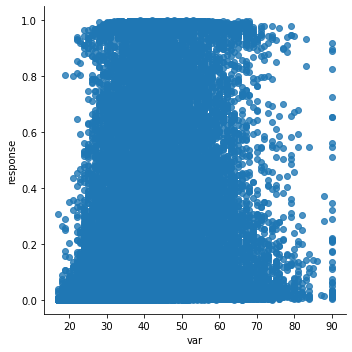

In [37]:
sns.lmplot(x='var',y='response',data=var_data,fit_reg=False)

In [38]:
import statsmodels.api as sn


In [39]:
smooth_data=sn.nonparametric.lowess(var_data['response'],var_data['var'])

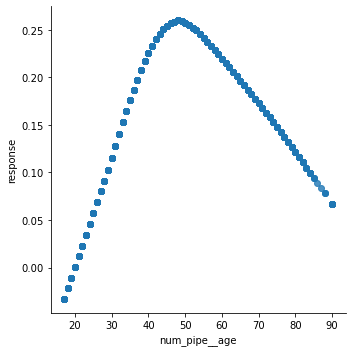

In [40]:
df=pd.DataFrame({'response':smooth_data[:,1],var_name:smooth_data[:,0]})

sns.lmplot(x=var_name,y='response',data=df,fit_reg=False)

In [41]:
x_train.columns

Index(['cat_pipe__workclass_ Private', 'cat_pipe__workclass_ Self-emp-not-inc',
       'cat_pipe__workclass_ Local-gov', 'cat_pipe__workclass_ ?',
       'cat_pipe__workclass_ State-gov', 'cat_pipe__workclass_ Self-emp-inc',
       'cat_pipe__workclass_ Federal-gov',
       'cat_pipe__marital.status_ Married-civ-spouse',
       'cat_pipe__marital.status_ Never-married',
       'cat_pipe__marital.status_ Divorced',
       'cat_pipe__marital.status_ Separated',
       'cat_pipe__marital.status_ Widowed',
       'cat_pipe__marital.status_ Married-spouse-absent',
       'cat_pipe__occupation_ Prof-specialty',
       'cat_pipe__occupation_ Craft-repair',
       'cat_pipe__occupation_ Exec-managerial',
       'cat_pipe__occupation_ Adm-clerical', 'cat_pipe__occupation_ Sales',
       'cat_pipe__occupation_ Other-service',
       'cat_pipe__occupation_ Machine-op-inspct', 'cat_pipe__occupation_ ?',
       'cat_pipe__occupation_ Transport-moving',
       'cat_pipe__occupation_ Handlers-cleaner

In [42]:
var_name='num_pipe__education.num'

preds=rf.predict_proba(x_train)[:,1]

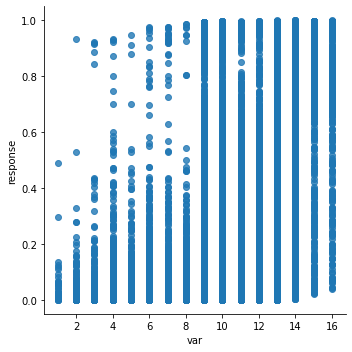

In [43]:
import seaborn as sns

var_data=pd.DataFrame({'var':x_train[var_name],'response':preds})
sns.lmplot(x='var',y='response',data=var_data,fit_reg=False)

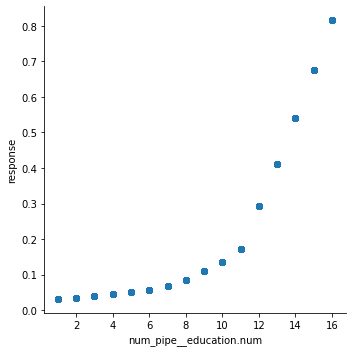

In [44]:
import statsmodels.api as sn

smooth_data=sn.nonparametric.lowess(var_data['response'],var_data['var'])

df=pd.DataFrame({'response':smooth_data[:,1],var_name:smooth_data[:,0]})

sns.lmplot(x=var_name,y='response',data=df,fit_reg=False)

# Extra Trees

In [ ]:
from sklearn.ensemble import 